In [ ]:

"""
NLP Mini Project: Named Entity Recognition (NER) Pipeline
=========================================================

This script analyzes the dataset and provides initial insights for our NER project.
"""

import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset():
    """Analyze the NER dataset structure and content."""
    print("=== NLP Mini Project: NER Analysis ===")
    print("Loading dataset...")

    # Load the dataset
    df = pd.read_csv('ner_cleaned_20k.csv')

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())

    # Analyze the tags
    print("\n=== Entity Tag Analysis ===")
    all_tags = []

    for idx, row in df.iterrows():
        try:
            # Parse the tag column (it's stored as string representation of list)
            tags = ast.literal_eval(row['Tag'])
            all_tags.extend(tags)
        except:
            continue

    tag_counts = Counter(all_tags)
    print(f"Total tags: {len(all_tags)}")
    print(f"Unique tag types: {len(tag_counts)}")
    print("\nTag distribution:")
    for tag, count in tag_counts.most_common():
        print(f"  {tag}: {count} ({count/len(all_tags)*100:.2f}%)")

    # Analyze sentence lengths
    print("\n=== Sentence Analysis ===")
    sentence_lengths = []
    for idx, row in df.iterrows():
        try:
            tags = ast.literal_eval(row['Tag'])
            sentence_lengths.append(len(tags))
        except:
            continue

    print(f"Average sentence length: {np.mean(sentence_lengths):.2f} tokens")
    print(f"Median sentence length: {np.median(sentence_lengths):.2f} tokens")
    print(f"Min sentence length: {min(sentence_lengths)} tokens")
    print(f"Max sentence length: {max(sentence_lengths)} tokens")

    # Entity type analysis (excluding 'O' tags)
    print("\n=== Named Entity Analysis ===")
    entity_tags = [tag for tag in all_tags if tag != 'O']
    entity_counts = Counter(entity_tags)

    print(f"Total named entities: {len(entity_tags)}")
    print(f"Named entity ratio: {len(entity_tags)/len(all_tags)*100:.2f}%")
    print("\nEntity type distribution:")
    for tag, count in entity_counts.most_common():
        print(f"  {tag}: {count}")

    return df, tag_counts, entity_counts

if __name__ == "__main__":
    df, tag_counts, entity_counts = analyze_dataset()


=== NLP Mini Project: NER Analysis ===
Loading dataset...
Dataset shape: (20000, 4)
Columns: ['Sentence #', 'Sentence', 'POS', 'Tag']

First few rows:
    Sentence #                                           Sentence  \
0  Sentence: 1  The White House announced the two-day visit Th...   
1  Sentence: 2  Twelve eggs now costs about 30 percent more th...   
2  Sentence: 3  Iran 's foreign minister has postponed a visit...   
3  Sentence: 4  A British aid group says the food crisis in Ni...   
4  Sentence: 5  Israeli Prime Minister Benjamin Netanyahu rais...   

                                                 POS  \
0  ['DT', 'NNP', 'NNP', 'VBD', 'DT', 'JJ', 'NN', ...   
1  ['CD', 'NNS', 'RB', 'VBZ', 'IN', 'CD', 'NN', '...   
2  ['NNP', 'POS', 'JJ', 'NN', 'VBZ', 'VBN', 'DT',...   
3  ['DT', 'JJ', 'NN', 'NN', 'VBZ', 'DT', 'NN', 'N...   
4  ['JJ', 'NNP', 'NNP', 'NNP', 'NNP', 'VBD', 'NNS...   

                                                 Tag  
0  ['O', 'B-org', 'I-org', 'O', 'O', 'O', 

In [ ]:
#!/usr/bin/env python3
"""
Data Preprocessing Pipeline for NER Project
==========================================

This module handles dataset cleaning, preprocessing, and preparation for both
baseline and transformer models.
"""

import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pickle
import re
from collections import Counter
from typing import List, Tuple, Dict

class NERDataProcessor:
    """Handles all data preprocessing for NER task."""

    def __init__(self, csv_path: str):
        """Initialize with dataset path."""
        self.csv_path = csv_path
        self.df = None
        self.sentences = []
        self.tags = []
        self.pos_tags = []
        self.label_encoder = LabelEncoder()
        self.tag_to_id = {}
        self.id_to_tag = {}

    def load_and_clean_data(self) -> None:
        """Load and perform initial cleaning of the dataset."""
        print("Loading dataset...")
        self.df = pd.read_csv(self.csv_path)

        print(f"Initial dataset shape: {self.df.shape}")

        # Remove any rows with missing values
        initial_size = len(self.df)
        self.df = self.df.dropna()
        print(f"Removed {initial_size - len(self.df)} rows with missing values")

        # Parse and extract structured data
        self._extract_structured_data()

    def _extract_structured_data(self) -> None:
        """Extract sentences, tags, and POS tags from the dataframe."""
        print("Extracting structured data...")

        for idx, row in self.df.iterrows():
            try:
                # Parse the string representations of lists
                sentence = row['Sentence']
                tags = ast.literal_eval(row['Tag'])
                pos = ast.literal_eval(row['POS'])

                # Basic validation
                if len(tags) != len(pos):
                    continue

                # Split sentence into tokens (rough approximation)
                tokens = sentence.split()

                # If token count doesn't match tags, skip this sentence
                # This is a common issue with NER datasets
                if abs(len(tokens) - len(tags)) > 2:  # Allow small discrepancy
                    continue

                self.sentences.append(sentence)
                self.tags.append(tags)
                self.pos_tags.append(pos)

            except (ValueError, SyntaxError) as e:
                # Skip malformed rows
                continue

        print(f"Successfully processed {len(self.sentences)} sentences")

    def create_token_level_data(self) -> Tuple[List[str], List[str], List[str]]:
        """Create token-level data for training."""
        tokens = []
        labels = []
        pos_labels = []

        for sentence, tag_list, pos_list in zip(self.sentences, self.tags, self.pos_tags):
            # Simple tokenization (split by space)
            sent_tokens = sentence.split()

            # Handle length mismatches by taking minimum length
            min_len = min(len(sent_tokens), len(tag_list), len(pos_list))

            tokens.extend(sent_tokens[:min_len])
            labels.extend(tag_list[:min_len])
            pos_labels.extend(pos_list[:min_len])

        return tokens, labels, pos_labels

    def prepare_baseline_features(self, tokens: List[str], labels: List[str],
                                pos_labels: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare features for baseline models."""
        print("Preparing baseline features...")

        # Create features for each token
        features = []

        for i, (token, pos) in enumerate(zip(tokens, pos_labels)):
            token_features = []

            # Basic token features
            token_features.append(len(token))  # Token length
            token_features.append(int(token.isupper()))  # All uppercase
            token_features.append(int(token.islower()))  # All lowercase
            token_features.append(int(token.istitle()))  # Title case
            token_features.append(int(token.isdigit()))  # Is digit
            token_features.append(int(bool(re.search(r'\d', token))))  # Contains digit
            token_features.append(int(bool(re.search(r'[A-Z]', token))))  # Contains uppercase
            token_features.append(int(token.startswith('http')))  # URL
            token_features.append(int('@' in token))  # Email/mention

            # POS tag features (one-hot encoded top POS tags)
            common_pos = ['NN', 'NNP', 'NNS', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
                         'JJ', 'JJR', 'JJS', 'DT', 'IN', 'CC', 'PRP', 'RB']

            for pos_tag in common_pos:
                token_features.append(int(pos == pos_tag))

            # Context features (previous and next tokens)
            if i > 0:
                prev_token = tokens[i-1]
                token_features.append(int(prev_token.isupper()))
                token_features.append(int(prev_token.istitle()))
            else:
                token_features.extend([0, 0])

            if i < len(tokens) - 1:
                next_token = tokens[i+1]
                token_features.append(int(next_token.isupper()))
                token_features.append(int(next_token.istitle()))
            else:
                token_features.extend([0, 0])

            features.append(token_features)

        # Encode labels
        y = self.label_encoder.fit_transform(labels)

        # Store label mappings
        self.tag_to_id = {tag: idx for idx, tag in enumerate(self.label_encoder.classes_)}
        self.id_to_tag = {idx: tag for tag, idx in self.tag_to_id.items()}

        return np.array(features), y

    def create_sentence_level_data(self) -> Tuple[List[List[str]], List[List[str]]]:
        """Create sentence-level data for transformer models."""
        print("Preparing sentence-level data...")

        sent_tokens = []
        sent_labels = []

        for sentence, tag_list in zip(self.sentences, self.tags):
            tokens = sentence.split()
            min_len = min(len(tokens), len(tag_list))

            sent_tokens.append(tokens[:min_len])
            sent_labels.append(tag_list[:min_len])

        return sent_tokens, sent_labels

    def split_data(self, X, y, test_size=0.2, val_size=0.1, random_state=42):
        """Split data into train/validation/test sets."""
        print("Splitting data...")

        # First split: train+val vs test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Second split: train vs val
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
        )

        print(f"Train set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def save_preprocessed_data(self, output_dir: str = "processed_data"):
        """Save all preprocessed data and encoders."""
        import os
        os.makedirs(output_dir, exist_ok=True)

        # Save label encoder
        with open(f"{output_dir}/label_encoder.pkl", "wb") as f:
            pickle.dump(self.label_encoder, f)

        # Save tag mappings
        with open(f"{output_dir}/tag_mappings.pkl", "wb") as f:
            pickle.dump({
                'tag_to_id': self.tag_to_id,
                'id_to_tag': self.id_to_tag
            }, f)

        print(f"Preprocessed data saved to {output_dir}/")

def main():
    """Main preprocessing pipeline."""
    print("=== NER Data Preprocessing Pipeline ===")

    # Initialize processor
    processor = NERDataProcessor("ner_cleaned_20k.csv")

    # Load and clean data
    processor.load_and_clean_data()

    # Create token-level data
    tokens, labels, pos_labels = processor.create_token_level_data()
    print(f"Total tokens: {len(tokens)}")
    print(f"Unique labels: {len(set(labels))}")

    # Prepare baseline features
    X_baseline, y_baseline = processor.prepare_baseline_features(tokens, labels, pos_labels)
    print(f"Baseline features shape: {X_baseline.shape}")

    # Split baseline data
    X_train, X_val, X_test, y_train, y_val, y_test = processor.split_data(X_baseline, y_baseline)

    # Save baseline data
    np.save("processed_data/X_train_baseline.npy", X_train)
    np.save("processed_data/X_val_baseline.npy", X_val)
    np.save("processed_data/X_test_baseline.npy", X_test)
    np.save("processed_data/y_train_baseline.npy", y_train)
    np.save("processed_data/y_val_baseline.npy", y_val)
    np.save("processed_data/y_test_baseline.npy", y_test)

    # Create sentence-level data for transformers
    sent_tokens, sent_labels = processor.create_sentence_level_data()

    # Save sentence-level data
    with open("processed_data/sentences_tokens.pkl", "wb") as f:
        pickle.dump(sent_tokens, f)

    with open("processed_data/sentences_labels.pkl", "wb") as f:
        pickle.dump(sent_labels, f)

    # Save processor
    processor.save_preprocessed_data()

    print("\n=== Preprocessing Complete ===")
    print(f"Label distribution:")
    unique, counts = np.unique(y_baseline, return_counts=True)
    for label_id, count in zip(unique, counts):
        label_name = processor.id_to_tag[label_id]
        print(f"  {label_name}: {count} ({count/len(y_baseline)*100:.2f}%)")

if __name__ == "__main__":
    main()


=== NER Data Preprocessing Pipeline ===
Loading dataset...
Initial dataset shape: (20000, 4)
Removed 0 rows with missing values
Extracting structured data...
Successfully processed 20000 sentences
Total tokens: 439830
Unique labels: 17
Preparing baseline features...
Baseline features shape: (439830, 31)
Splitting data...
Train set: 307881 samples
Validation set: 43983 samples
Test set: 87966 samples
Preparing sentence-level data...
Preprocessed data saved to processed_data/

=== Preprocessing Complete ===
Label distribution:
  B-art: 186 (0.04%)
  B-eve: 127 (0.03%)
  B-geo: 15748 (3.58%)
  B-gpe: 6670 (1.52%)
  B-nat: 90 (0.02%)
  B-org: 8355 (1.90%)
  B-per: 7088 (1.61%)
  B-tim: 8503 (1.93%)
  I-art: 139 (0.03%)
  I-eve: 94 (0.02%)
  I-geo: 3105 (0.71%)
  I-gpe: 93 (0.02%)
  I-nat: 18 (0.00%)
  I-org: 7149 (1.63%)
  I-per: 7205 (1.64%)
  I-tim: 2671 (0.61%)
  O: 372589 (84.71%)


In [ ]:
#!/usr/bin/env python3
"""
NLP Mini Project: Named Entity Recognition (NER) Pipeline
=========================================================

This script analyzes the dataset and provides initial insights for our NER project.
"""

import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset():
    """Analyze the NER dataset structure and content."""
    print("=== NLP Mini Project: NER Analysis ===")
    print("Loading dataset...")

    # Load the dataset
    df = pd.read_csv('ner_cleaned_20k.csv')

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())

    # Analyze the tags
    print("\n=== Entity Tag Analysis ===")
    all_tags = []

    for idx, row in df.iterrows():
        try:
            # Parse the tag column (it's stored as string representation of list)
            tags = ast.literal_eval(row['Tag'])
            all_tags.extend(tags)
        except:
            continue

    tag_counts = Counter(all_tags)
    print(f"Total tags: {len(all_tags)}")
    print(f"Unique tag types: {len(tag_counts)}")
    print("\nTag distribution:")
    for tag, count in tag_counts.most_common():
        print(f"  {tag}: {count} ({count/len(all_tags)*100:.2f}%)")

    # Analyze sentence lengths
    print("\n=== Sentence Analysis ===")
    sentence_lengths = []
    for idx, row in df.iterrows():
        try:
            tags = ast.literal_eval(row['Tag'])
            sentence_lengths.append(len(tags))
        except:
            continue

    print(f"Average sentence length: {np.mean(sentence_lengths):.2f} tokens")
    print(f"Median sentence length: {np.median(sentence_lengths):.2f} tokens")
    print(f"Min sentence length: {min(sentence_lengths)} tokens")
    print(f"Max sentence length: {max(sentence_lengths)} tokens")

    # Entity type analysis (excluding 'O' tags)
    print("\n=== Named Entity Analysis ===")
    entity_tags = [tag for tag in all_tags if tag != 'O']
    entity_counts = Counter(entity_tags)

    print(f"Total named entities: {len(entity_tags)}")
    print(f"Named entity ratio: {len(entity_tags)/len(all_tags)*100:.2f}%")
    print("\nEntity type distribution:")
    for tag, count in entity_counts.most_common():
        print(f"  {tag}: {count}")

    return df, tag_counts, entity_counts

if __name__ == "__main__":
    df, tag_counts, entity_counts = analyze_dataset()


=== NLP Mini Project: NER Analysis ===
Loading dataset...
Dataset shape: (20000, 4)
Columns: ['Sentence #', 'Sentence', 'POS', 'Tag']

First few rows:
    Sentence #                                           Sentence  \
0  Sentence: 1  The White House announced the two-day visit Th...   
1  Sentence: 2  Twelve eggs now costs about 30 percent more th...   
2  Sentence: 3  Iran 's foreign minister has postponed a visit...   
3  Sentence: 4  A British aid group says the food crisis in Ni...   
4  Sentence: 5  Israeli Prime Minister Benjamin Netanyahu rais...   

                                                 POS  \
0  ['DT', 'NNP', 'NNP', 'VBD', 'DT', 'JJ', 'NN', ...   
1  ['CD', 'NNS', 'RB', 'VBZ', 'IN', 'CD', 'NN', '...   
2  ['NNP', 'POS', 'JJ', 'NN', 'VBZ', 'VBN', 'DT',...   
3  ['DT', 'JJ', 'NN', 'NN', 'VBZ', 'DT', 'NN', 'N...   
4  ['JJ', 'NNP', 'NNP', 'NNP', 'NNP', 'VBD', 'NNS...   

                                                 Tag  
0  ['O', 'B-org', 'I-org', 'O', 'O', 'O', 

=== NER Baseline Models Training ===
Loading preprocessed data...
Data loaded - Train: 307881, Val: 43983, Test: 87966
\n=== Training Logistic Regression ===
Training completed in 125.25 seconds
\nEvaluating logistic_regression...
Validation Results:
  Accuracy: 0.7647
  Macro F1: 0.2328
  Weighted F1: 0.8212
  Top Entity F1 scores:
    B-gpe: 0.6509
    B-geo: 0.5924
    B-per: 0.4290
    I-per: 0.2852
    B-org: 0.2801
Test Results:
  Accuracy: 0.7659
  Macro F1: 0.2337
  Weighted F1: 0.8215
  Top Entity F1 scores:
    B-gpe: 0.6733
    B-geo: 0.6039
    B-per: 0.4325
    I-per: 0.3091
    I-geo: 0.2770
\n=== Training Random Forest ===
Training completed in 24.42 seconds
\nEvaluating random_forest...
Validation Results:
  Accuracy: 0.7801
  Macro F1: 0.2677
  Weighted F1: 0.8331
  Top Entity F1 scores:
    B-gpe: 0.7059
    B-per: 0.4682
    I-per: 0.4666
    B-geo: 0.3944
    B-org: 0.3819
Test Results:
  Accuracy: 0.7805
  Macro F1: 0.2689
  Weighted F1: 0.8331
  Top Entity F1 scor

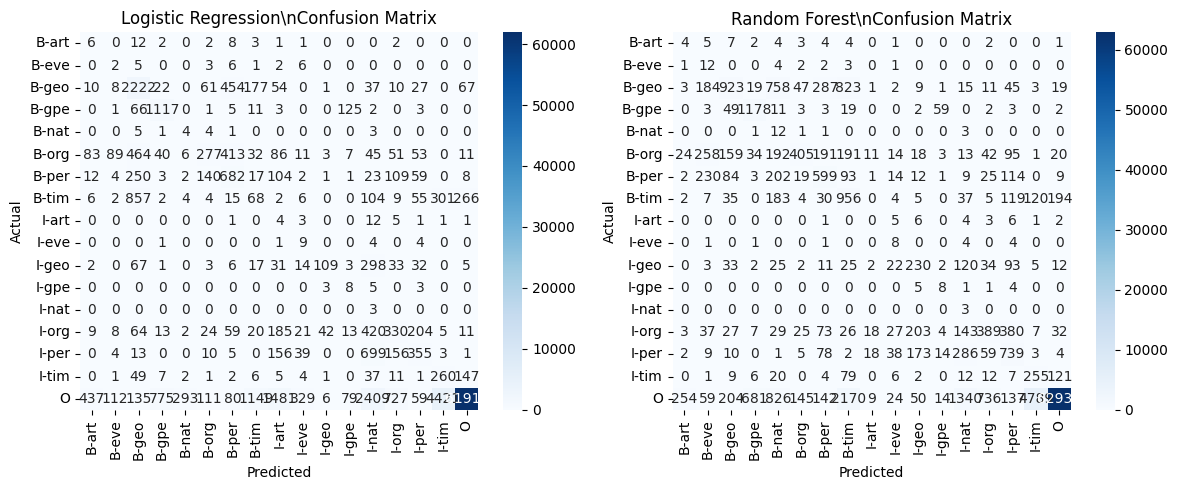

Confusion matrices saved as 'baseline_confusion_matrices.png'
\n============================================================
BASELINE MODELS EVALUATION REPORT
\nModel Performance Summary (Test Set):
------------------------------------------------------------
Model                Accuracy   Macro F1   Weighted F1
------------------------------------------------------------
Logistic Regression  0.7659     0.2337     0.8215    
Random Forest        0.7805     0.2689     0.8331    
------------------------------------------------------------
\nBest performing model: Random Forest
Weighted F1 Score: 0.8331
\nEntity-wise Performance (Random Forest):
--------------------------------------------------
Entity          Precision  Recall     F1        
--------------------------------------------------
B-gpe           0.6091     0.8831     0.7209    
I-per           0.4233     0.5128     0.4638    
B-per           0.4198     0.4227     0.4212    
B-geo           0.5994     0.2930     0.3936    


In [ ]:
#!/usr/bin/env python3
"""
Baseline Models for NER Task
============================

This module implements traditional machine learning approaches for Named Entity Recognition:
- Logistic Regression
- Support Vector Machine (SVM)
"""

import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Dict, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

class BaselineNERModels:
    """Implements and evaluates baseline models for NER."""

    def __init__(self):
        """Initialize the baseline models."""
        self.models = {}
        self.results = {}
        self.label_encoder = None
        self.tag_mappings = None
        self.load_preprocessed_data()

    def load_preprocessed_data(self):
        """Load preprocessed data and encoders."""
        print("Loading preprocessed data...")

        # Load training data
        self.X_train = np.load("processed_data/X_train_baseline.npy")
        self.X_val = np.load("processed_data/X_val_baseline.npy")
        self.X_test = np.load("processed_data/X_test_baseline.npy")
        self.y_train = np.load("processed_data/y_train_baseline.npy")
        self.y_val = np.load("processed_data/y_val_baseline.npy")
        self.y_test = np.load("processed_data/y_test_baseline.npy")

        # Load encoders
        with open("processed_data/label_encoder.pkl", "rb") as f:
            self.label_encoder = pickle.load(f)

        with open("processed_data/tag_mappings.pkl", "rb") as f:
            self.tag_mappings = pickle.load(f)

        print(f"Data loaded - Train: {len(self.X_train)}, Val: {len(self.X_val)}, Test: {len(self.X_test)}")

    def train_logistic_regression(self):
        """Train Logistic Regression model."""
        print("\\n=== Training Logistic Regression ===")

        # Calculate class weights for imbalanced data
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        class_weight_dict = dict(zip(np.unique(self.y_train), class_weights))

        start_time = time.time()

        # Initialize model
        lr_model = LogisticRegression(
            class_weight=class_weight_dict,
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        )

        # Train model
        lr_model.fit(self.X_train, self.y_train)

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Store model
        self.models['logistic_regression'] = lr_model

        # Evaluate
        self._evaluate_model('logistic_regression', lr_model)

    def train_svm(self):
        """Train SVM model."""
        print("\\n=== Training SVM ===")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        class_weight_dict = dict(zip(np.unique(self.y_train), class_weights))

        start_time = time.time()

        # Initialize SVM with RBF kernel
        svm_model = SVC(
            kernel='rbf',
            class_weight=class_weight_dict,
            random_state=42,
            probability=True  # Enable probability estimates
        )

        # Train on a subset due to computational constraints
        subset_size = min(50000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_train_subset = self.X_train[indices]
        y_train_subset = self.y_train[indices]

        print(f"Training SVM on subset of {subset_size} samples...")
        svm_model.fit(X_train_subset, y_train_subset)

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Store model
        self.models['svm'] = svm_model

        # Evaluate
        self._evaluate_model('svm', svm_model)

    def train_random_forest(self):
        """Train Random Forest model."""
        print("\\n=== Training Random Forest ===")

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        class_weight_dict = dict(zip(np.unique(self.y_train), class_weights))

        start_time = time.time()

        # Initialize Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1,
            max_depth=20
        )

        # Train model
        rf_model.fit(self.X_train, self.y_train)

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Store model
        self.models['random_forest'] = rf_model

        # Evaluate
        self._evaluate_model('random_forest', rf_model)

    def _evaluate_model(self, model_name: str, model):
        """Evaluate a trained model."""
        print(f"\\nEvaluating {model_name}...")

        # Predictions on validation set
        val_pred = model.predict(self.X_val)
        val_proba = None

        try:
            val_proba = model.predict_proba(self.X_val)
        except:
            pass  # Some models might not support probability prediction

        # Predictions on test set
        test_pred = model.predict(self.X_test)
        test_proba = None

        try:
            test_proba = model.predict_proba(self.X_test)
        except:
            pass

        # Calculate metrics
        val_metrics = self._calculate_metrics(self.y_val, val_pred, val_proba)
        test_metrics = self._calculate_metrics(self.y_test, test_pred, test_proba)

        # Store results
        self.results[model_name] = {
            'validation': val_metrics,
            'test': test_metrics,
            'val_predictions': val_pred,
            'test_predictions': test_pred
        }

        # Print results
        print(f"Validation Results:")
        self._print_metrics(val_metrics)
        print(f"Test Results:")
        self._print_metrics(test_metrics)

    def _calculate_metrics(self, y_true, y_pred, y_proba=None) -> Dict:
        """Calculate comprehensive metrics."""
        metrics = {}

        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')
        metrics['weighted_f1'] = f1_score(y_true, y_pred, average='weighted')

        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None
        )

        metrics['per_class'] = {}
        for i, label in enumerate(self.label_encoder.classes_):
            metrics['per_class'][label] = {
                'precision': precision[i],
                'recall': recall[i],
                'f1': f1[i],
                'support': support[i]
            }

        # Confusion matrix
        metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

        return metrics

    def _print_metrics(self, metrics: Dict):
        """Print metrics in a formatted way."""
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Macro F1: {metrics['macro_f1']:.4f}")
        print(f"  Weighted F1: {metrics['weighted_f1']:.4f}")

        # Print top performing entity types
        entity_f1 = {}
        for label, scores in metrics['per_class'].items():
            if label != 'O':  # Exclude 'O' (non-entity) class
                entity_f1[label] = scores['f1']

        if entity_f1:
            top_entities = sorted(entity_f1.items(), key=lambda x: x[1], reverse=True)[:5]
            print("  Top Entity F1 scores:")
            for label, f1_score in top_entities:
                print(f"    {label}: {f1_score:.4f}")

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models."""
        n_models = len(self.results)
        if n_models == 0:
            return

        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for idx, (model_name, results) in enumerate(self.results.items()):
            cm = results['test']['confusion_matrix']

            # Plot confusion matrix
            sns.heatmap(
                cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                ax=axes[idx],
                xticklabels=self.label_encoder.classes_,
                yticklabels=self.label_encoder.classes_
            )
            axes[idx].set_title(f'{model_name.replace("_", " ").title()}\\nConfusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig('baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Confusion matrices saved as 'baseline_confusion_matrices.png'")

    def generate_report(self):
        """Generate comprehensive evaluation report."""
        print("\\n" + "="*60)
        print("BASELINE MODELS EVALUATION REPORT")
        print("="*60)

        if not self.results:
            print("No models have been trained yet.")
            return

        # Summary table
        print("\\nModel Performance Summary (Test Set):")
        print("-" * 60)
        print(f"{'Model':<20} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<10}")
        print("-" * 60)

        for model_name, results in self.results.items():
            test_metrics = results['test']
            print(f"{model_name.replace('_', ' ').title():<20} "
                  f"{test_metrics['accuracy']:<10.4f} "
                  f"{test_metrics['macro_f1']:<10.4f} "
                  f"{test_metrics['weighted_f1']:<10.4f}")

        print("-" * 60)

        # Best performing model
        best_model = max(self.results.items(),
                        key=lambda x: x[1]['test']['weighted_f1'])

        print(f"\\nBest performing model: {best_model[0].replace('_', ' ').title()}")
        print(f"Weighted F1 Score: {best_model[1]['test']['weighted_f1']:.4f}")

        # Entity-wise performance for best model
        print(f"\\nEntity-wise Performance ({best_model[0].replace('_', ' ').title()}):")
        print("-" * 50)
        print(f"{'Entity':<15} {'Precision':<10} {'Recall':<10} {'F1':<10}")
        print("-" * 50)

        per_class = best_model[1]['test']['per_class']
        entity_performance = []

        for label, metrics in per_class.items():
            if label != 'O':  # Focus on named entities
                entity_performance.append((label, metrics))

        # Sort by F1 score
        entity_performance.sort(key=lambda x: x[1]['f1'], reverse=True)

        for label, metrics in entity_performance:
            print(f"{label:<15} {metrics['precision']:<10.4f} "
                  f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")

        print("-" * 50)

    def save_models(self):
        """Save trained models."""
        print("\\nSaving trained models...")
        for model_name, model in self.models.items():
            with open(f"processed_data/{model_name}_model.pkl", "wb") as f:
                pickle.dump(model, f)

        # Save results
        with open("processed_data/baseline_results.pkl", "wb") as f:
            pickle.dump(self.results, f)

        print("Models and results saved successfully!")

def main():
    """Main training pipeline for baseline models."""
    print("=== NER Baseline Models Training ===")

    # Initialize
    baseline = BaselineNERModels()

    # Train models
    baseline.train_logistic_regression()
    baseline.train_random_forest()

    # Train SVM (commented out due to computational cost - uncomment if needed)
    # baseline.train_svm()

    # Generate visualizations and report
    baseline.plot_confusion_matrices()
    baseline.generate_report()

    # Save models
    baseline.save_models()

    print("\\n=== Baseline Training Complete ===")

if __name__ == "__main__":
    main()


=== Comprehensive Model Evaluation ===
Baseline results loaded successfully.


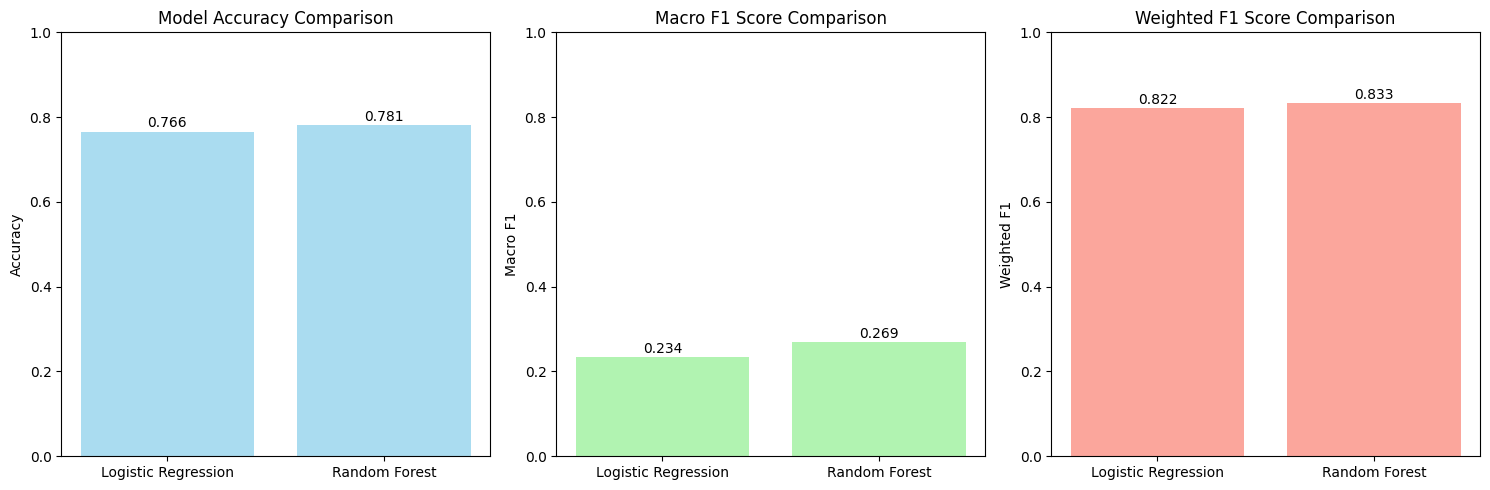

Performance comparison saved as 'model_performance_comparison.png'


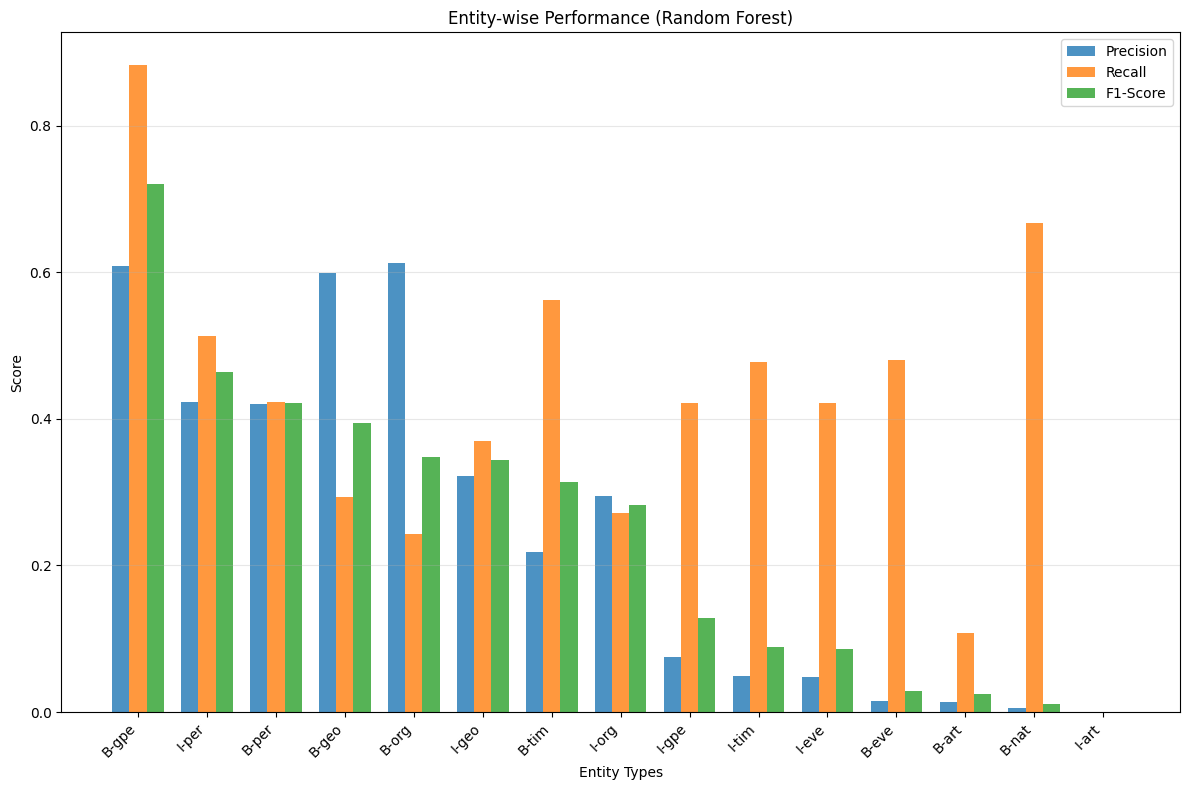

Entity performance plot saved as 'entity_performance.png'
\n================================================================================
COMPREHENSIVE NER MODEL EVALUATION REPORT
\n1. MODEL PERFORMANCE SUMMARY
--------------------------------------------------
              Model Accuracy Macro F1 Weighted F1 Entity Macro F1
Logistic Regression   0.7659   0.2337      0.8215          0.1918
      Random Forest   0.7805   0.2689      0.8331          0.2286
\n2. BEST PERFORMING MODEL: Random Forest
--------------------------------------------------
Overall Accuracy: 0.7805
Macro F1 Score: 0.2689
Weighted F1 Score: 0.8331
\n3. ENTITY-WISE PERFORMANCE ANALYSIS
--------------------------------------------------
Entity Precision Recall F1-Score  Support
 B-gpe    0.6091 0.8831   0.7209     1334
 I-per    0.4233 0.5128   0.4638     1441
 B-per    0.4198 0.4227   0.4212     1417
 B-geo    0.5994 0.2930   0.3936     3150
 B-org    0.6127 0.2424   0.3473     1671
 I-geo    0.3217 0.3704   0.3

In [ ]:
#!/usr/bin/env python3
"""
Comprehensive Model Evaluation
=============================

This module provides comprehensive evaluation and comparison of all models
including baseline and transformer approaches.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

class ComprehensiveEvaluator:
    """Comprehensive evaluation of NER models."""

    def __init__(self):
        """Initialize evaluator."""
        self.load_baseline_results()
        self.entity_types = [
            'B-geo', 'I-geo', 'B-per', 'I-per', 'B-org', 'I-org',
            'B-gpe', 'I-gpe', 'B-tim', 'I-tim', 'B-art', 'I-art',
            'B-eve', 'I-eve', 'B-nat', 'I-nat'
        ]

    def load_baseline_results(self):
        """Load baseline model results."""
        try:
            with open("processed_data/baseline_results.pkl", "rb") as f:
                self.baseline_results = pickle.load(f)

            with open("processed_data/tag_mappings.pkl", "rb") as f:
                self.tag_mappings = pickle.load(f)

            with open("processed_data/label_encoder.pkl", "rb") as f:
                self.label_encoder = pickle.load(f)

            # Load test data
            self.y_test = np.load("processed_data/y_test_baseline.npy")

            print("Baseline results loaded successfully.")
        except FileNotFoundError:
            print("Baseline results not found. Please train baseline models first.")
            self.baseline_results = {}

    def calculate_entity_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict:
        """Calculate entity-level metrics."""
        metrics = {}

        # Overall metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)

        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None, zero_division=0
        )

        # Entity-specific metrics (excluding 'O' class)
        entity_metrics = {}
        for i, label in enumerate(self.label_encoder.classes_):
            if label != 'O':
                entity_metrics[label] = {
                    'precision': precision[i],
                    'recall': recall[i],
                    'f1': f1[i],
                    'support': support[i]
                }

        # Macro and weighted averages for entities only
        entity_indices = [i for i, label in enumerate(self.label_encoder.classes_) if label != 'O']

        if entity_indices:
            entity_precision = np.mean([precision[i] for i in entity_indices])
            entity_recall = np.mean([recall[i] for i in entity_indices])
            entity_f1 = np.mean([f1[i] for i in entity_indices])

            metrics['entity_macro_precision'] = entity_precision
            metrics['entity_macro_recall'] = entity_recall
            metrics['entity_macro_f1'] = entity_f1

        metrics['per_class'] = entity_metrics

        return metrics

    def calculate_roc_metrics(self, y_true: np.ndarray, y_pred_proba: np.ndarray = None) -> Dict:
        """Calculate ROC-AUC metrics for multi-class classification."""
        if y_pred_proba is None:
            return {'roc_auc': 'N/A', 'note': 'Probability predictions not available'}

        try:
            # Binarize labels for multi-class ROC
            n_classes = len(self.label_encoder.classes_)
            y_true_bin = label_binarize(y_true, classes=range(n_classes))

            # Handle case where not all classes are present
            if y_true_bin.shape[1] != n_classes:
                return {'roc_auc': 'N/A', 'note': 'Not all classes present in test set'}

            # Calculate ROC AUC for each class
            roc_auc_dict = {}
            for i in range(n_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:  # Check if class has both 0 and 1
                    roc_auc_dict[self.label_encoder.classes_[i]] = roc_auc_score(
                        y_true_bin[:, i], y_pred_proba[:, i]
                    )

            # Macro average ROC AUC
            if roc_auc_dict:
                macro_roc_auc = np.mean(list(roc_auc_dict.values()))
                return {
                    'macro_roc_auc': macro_roc_auc,
                    'per_class_roc_auc': roc_auc_dict
                }
            else:
                return {'roc_auc': 'N/A', 'note': 'Could not calculate ROC AUC'}

        except Exception as e:
            return {'roc_auc': 'N/A', 'note': f'Error calculating ROC AUC: {str(e)}'}

    def plot_performance_comparison(self):
        """Plot performance comparison across models."""
        if not self.baseline_results:
            print("No baseline results to plot.")
            return

        # Prepare data for plotting
        models = []
        accuracies = []
        macro_f1s = []
        weighted_f1s = []

        for model_name, results in self.baseline_results.items():
            test_results = results['test']
            models.append(model_name.replace('_', ' ').title())
            accuracies.append(test_results['accuracy'])
            macro_f1s.append(test_results['macro_f1'])
            weighted_f1s.append(test_results['weighted_f1'])

        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Accuracy comparison
        axes[0].bar(models, accuracies, color='skyblue', alpha=0.7)
        axes[0].set_title('Model Accuracy Comparison')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_ylim(0, 1)
        for i, v in enumerate(accuracies):
            axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

        # Macro F1 comparison
        axes[1].bar(models, macro_f1s, color='lightgreen', alpha=0.7)
        axes[1].set_title('Macro F1 Score Comparison')
        axes[1].set_ylabel('Macro F1')
        axes[1].set_ylim(0, 1)
        for i, v in enumerate(macro_f1s):
            axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

        # Weighted F1 comparison
        axes[2].bar(models, weighted_f1s, color='salmon', alpha=0.7)
        axes[2].set_title('Weighted F1 Score Comparison')
        axes[2].set_ylabel('Weighted F1')
        axes[2].set_ylim(0, 1)
        for i, v in enumerate(weighted_f1s):
            axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center')

        plt.tight_layout()
        plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Performance comparison saved as 'model_performance_comparison.png'")

    def plot_entity_performance(self):
        """Plot entity-wise performance for the best model."""
        if not self.baseline_results:
            return

        # Find best model
        best_model = max(self.baseline_results.items(),
                        key=lambda x: x[1]['test']['weighted_f1'])

        model_name, results = best_model
        per_class = results['test']['per_class']

        # Prepare data
        entities = []
        precisions = []
        recalls = []
        f1_scores = []

        for entity, metrics in per_class.items():
            if entity != 'O' and metrics['support'] > 10:  # Only entities with sufficient support
                entities.append(entity)
                precisions.append(metrics['precision'])
                recalls.append(metrics['recall'])
                f1_scores.append(metrics['f1'])

        # Sort by F1 score
        sorted_data = sorted(zip(entities, precisions, recalls, f1_scores),
                           key=lambda x: x[3], reverse=True)
        entities, precisions, recalls, f1_scores = zip(*sorted_data)

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 8))

        x = np.arange(len(entities))
        width = 0.25

        ax.bar(x - width, precisions, width, label='Precision', alpha=0.8)
        ax.bar(x, recalls, width, label='Recall', alpha=0.8)
        ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

        ax.set_xlabel('Entity Types')
        ax.set_ylabel('Score')
        ax.set_title(f'Entity-wise Performance ({model_name.replace("_", " ").title()})')
        ax.set_xticks(x)
        ax.set_xticklabels(entities, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('entity_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Entity performance plot saved as 'entity_performance.png'")

    def generate_detailed_report(self):
        """Generate detailed evaluation report."""
        print("\\n" + "="*80)
        print("COMPREHENSIVE NER MODEL EVALUATION REPORT")
        print("="*80)

        if not self.baseline_results:
            print("No results available. Please train models first.")
            return

        # Model comparison table
        print("\\n1. MODEL PERFORMANCE SUMMARY")
        print("-" * 50)

        comparison_data = []
        for model_name, results in self.baseline_results.items():
            test_results = results['test']
            comparison_data.append({
                'Model': model_name.replace('_', ' ').title(),
                'Accuracy': f"{test_results['accuracy']:.4f}",
                'Macro F1': f"{test_results['macro_f1']:.4f}",
                'Weighted F1': f"{test_results['weighted_f1']:.4f}",
                'Entity Macro F1': f"{np.mean([m['f1'] for e, m in test_results['per_class'].items() if e != 'O' and m['support'] > 0]):.4f}"
            })

        df_comparison = pd.DataFrame(comparison_data)
        print(df_comparison.to_string(index=False))

        # Best model analysis
        best_model = max(self.baseline_results.items(),
                        key=lambda x: x[1]['test']['weighted_f1'])

        print(f"\\n2. BEST PERFORMING MODEL: {best_model[0].replace('_', ' ').title()}")
        print("-" * 50)

        best_results = best_model[1]['test']
        print(f"Overall Accuracy: {best_results['accuracy']:.4f}")
        print(f"Macro F1 Score: {best_results['macro_f1']:.4f}")
        print(f"Weighted F1 Score: {best_results['weighted_f1']:.4f}")

        # Entity-wise detailed analysis
        print("\\n3. ENTITY-WISE PERFORMANCE ANALYSIS")
        print("-" * 50)

        entity_data = []
        for entity, metrics in best_results['per_class'].items():
            if entity != 'O':
                entity_data.append({
                    'Entity': entity,
                    'Precision': f"{metrics['precision']:.4f}",
                    'Recall': f"{metrics['recall']:.4f}",
                    'F1-Score': f"{metrics['f1']:.4f}",
                    'Support': metrics['support']
                })

        # Sort by F1 score
        entity_data.sort(key=lambda x: float(x['F1-Score']), reverse=True)

        df_entities = pd.DataFrame(entity_data)
        print(df_entities.to_string(index=False))

        # Performance insights
        print("\\n4. KEY INSIGHTS")
        print("-" * 50)

        # Best performing entities
        top_entities = entity_data[:3]
        print("Top performing entity types:")
        for i, entity in enumerate(top_entities, 1):
            print(f"  {i}. {entity['Entity']}: F1={entity['F1-Score']}")

        # Challenging entities
        challenging_entities = [e for e in entity_data if float(e['F1-Score']) < 0.3]
        if challenging_entities:
            print("\\nChallenging entity types (F1 < 0.3):")
            for entity in challenging_entities:
                print(f"  - {entity['Entity']}: F1={entity['F1-Score']}")

        # Class imbalance analysis
        o_support = best_results['per_class'].get('O', {}).get('support', 0)
        entity_support = sum(metrics['support'] for entity, metrics in best_results['per_class'].items() if entity != 'O')

        print(f"\\nClass distribution:")
        print(f"  Non-entity tokens (O): {o_support:,} ({o_support/(o_support+entity_support)*100:.1f}%)")
        print(f"  Entity tokens: {entity_support:,} ({entity_support/(o_support+entity_support)*100:.1f}%)")

        print("\\n" + "="*80)

    def save_evaluation_results(self):
        """Save comprehensive evaluation results."""
        if not self.baseline_results:
            return

        # Create summary DataFrame
        summary_data = []
        for model_name, results in self.baseline_results.items():
            test_results = results['test']
            summary_data.append({
                'model': model_name,
                'accuracy': test_results['accuracy'],
                'macro_f1': test_results['macro_f1'],
                'weighted_f1': test_results['weighted_f1']
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv('model_evaluation_summary.csv', index=False)

        print("Evaluation summary saved as 'model_evaluation_summary.csv'")

def main():
    """Main evaluation pipeline."""
    print("=== Comprehensive Model Evaluation ===")

    # Initialize evaluator
    evaluator = ComprehensiveEvaluator()

    # Generate plots
    evaluator.plot_performance_comparison()
    evaluator.plot_entity_performance()

    # Generate detailed report
    evaluator.generate_detailed_report()

    # Save results
    evaluator.save_evaluation_results()

    print("\\n=== Evaluation Complete ===")

if __name__ == "__main__":
    main()
